<a href="https://colab.research.google.com/github/taitip-supha/BADS7604_Group3/blob/main/experiment/6310422009_3layer_1-28node.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (1 - RUN) Seting Import package and Parameter

ref : 

In [ ]:
#Set Environment and Parameter
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score ,f1_score ,precision_score ,recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

import time

pd.set_option('display.max_columns', 100)



RANDOM_STATE = 2018
PREDS_RATIO = 0.5

# (2 - RUN) Prepar Data

## Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BADS7604_DL/data/creditcard.csv")
data_df.head(3)
print(f"Size od data frame {data_df.shape}")

Size od data frame (284807, 31)


In [ ]:
#Define predictors and target values
target = 'Class'
predictors = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10','V11', 'V12', 'V13', 'V14', 'V15',
                   'V16', 'V17', 'V18', 'V19','V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

In [ ]:
df_x = data_df[predictors]
df_y = data_df[target]

## Scaling predictors

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_x = pd.DataFrame(scaler.fit_transform(df_x))

## Split data in train, test

In [ ]:
TEST_SIZE = 0.20 # test size using_train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
print(f"Proportion of Target: {y_train.mean()}")

Proportion of Target: 0.0017204678619236761


## Oversampling Trainig Set

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = RANDOM_STATE ,sampling_strategy='minority')
x_train, y_train = smote.fit_resample(x_train,y_train)
print(f"Proportion after oversampling : {y_train.mean()}")

Proportion after oversampling : 0.5


## Prepare Data in Numpy

In [ ]:
#Predictor
x_train = x_train.values.astype(np.float32)
x_test  = x_test.values.astype(np.float32)
print( f" x_train.shape={x_train.shape}, x_train.dtype={x_train.dtype}, min(x_train)={np.min(x_train):0.4f}, max(x_train)={np.max(x_train):0.4f}")
print( f" x_test.shape={x_test.shape}, x_test.dtype={x_test.dtype}, min(x_test)={np.min(x_test):0.4f}, max(x_test)={np.max(x_test):0.4f}")

 x_train.shape=(454906, 29), x_train.dtype=float32, min(x_train)=0.0000, max(x_train)=1.0000
 x_test.shape=(56962, 29), x_test.dtype=float32, min(x_test)=0.0000, max(x_test)=1.0000


In [ ]:
#Target
y_train = y_train.values
y_test = y_test.values
print( f" y_train.shape={y_train.shape}, y_train.dtype={y_train.dtype}, min(y_train)={np.min(y_train)}, max(y_train)={np.max(y_train)}")
print( f" y_test.shape={y_test.shape}, y_test.dtype={y_test.dtype}, min(y_test)={np.min(y_test)}, max(y_test)={np.max(y_test)}")

 y_train.shape=(454906,), y_train.dtype=int64, min(y_train)=0, max(y_train)=1
 y_test.shape=(56962,), y_test.dtype=int64, min(y_test)=0, max(y_test)=1


## Create the network architecture

In [ ]:
model = tf.keras.models.Sequential()

#Input layer
model.add(tf.keras.Input(shape=(input_dim,)))

#Hidden layer
model.add(tf.keras.layers.Dense(32, activation='relu', name='hidden1')) #use defult weight initialization, don't use any regularization
model.add(tf.keras.layers.BatchNormalization(axis =-1, name='bn1'))

#output layer
model.add(tf.keras.layers.Dense(output_din, activation='softmax', name='output'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 32)                960       
                                                                 
 bn1 (BatchNormalization)    (None, 32)                128       
                                                                 
 output (Dense)              (None, 2)                 66        
                                                                 
Total params: 1,154
Trainable params: 1,090
Non-trainable params: 64
_________________________________________________________________


## Compile the model

In [ ]:
#Examples of compiling the model (only run one cell provided below)
#1) complie with default values for both optimizer and loss
# model.compile( optimizer='adam', loss='sparse_categorical_croseentropy', metrics=['acc'])
#2) complie + Hyperparameter tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['acc'])

## Training the model

In [ ]:
start_tm = time.time()
checkpoint_filepath = "bestmodel_epoch{epoch:02d}_valloss{val_loss:.2f}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                               save_weights_only=True, 
                                                               monitor='val_acc', 
                                                               model='max', 
                                                               save_best_only=True)
history = model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2, callbacks=[model_checkpoint_callback])
print(f">>>>> Training Time >>>> {time.time() - start_tm} seconds")

Epoch 1/20
2844/2844 [==============================] - 18s 6ms/step - loss: 0.1133 - acc: 0.9544 - val_loss: 0.2828 - val_acc: 0.8649
Epoch 2/20
2844/2844 [==============================] - 15s 5ms/step - loss: 0.1029 - acc: 0.9575 - val_loss: 0.2783 - val_acc: 0.8917
Epoch 3/20
2844/2844 [==============================] - 14s 5ms/step - loss: 0.0965 - acc: 0.9596 - val_loss: 0.2939 - val_acc: 0.8824
Epoch 4/20
2844/2844 [==============================] - 14s 5ms/step - loss: 0.0925 - acc: 0.9616 - val_loss: 0.0748 - val_acc: 0.9660
Epoch 5/20
2844/2844 [==============================] - 14s 5ms/step - loss: 0.0877 - acc: 0.9637 - val_loss: 0.1539 - val_acc: 0.9230
Epoch 6/20
2844/2844 [==============================] - 14s 5ms/step - loss: 0.0828 - acc: 0.9655 - val_loss: 0.1312 - val_acc: 0.9304
Epoch 7/20
2844/2844 [==============================] - 14s 5ms/step - loss: 0.0804 - acc: 0.9668 - val_loss: 0.0326 - val_acc: 0.9924
Epoch 8/20
2844/2844 [==============================] -

In [ ]:
#Inspect the save file (sorted by modification date,  newest first)
!ls -lt

total 200
-rw-r--r-- 1 root root 21056 Jan 26 13:43 bestmodel_epoch19_valloss0.00.hdf5
-rw-r--r-- 1 root root 21056 Jan 26 13:43 bestmodel_epoch18_valloss0.01.hdf5
-rw-r--r-- 1 root root 21056 Jan 26 13:43 bestmodel_epoch17_valloss0.02.hdf5
-rw-r--r-- 1 root root 21056 Jan 26 13:41 bestmodel_epoch09_valloss0.02.hdf5
-rw-r--r-- 1 root root 21056 Jan 26 13:40 bestmodel_epoch07_valloss0.03.hdf5
-rw-r--r-- 1 root root 21056 Jan 26 13:40 bestmodel_epoch04_valloss0.07.hdf5
-rw-r--r-- 1 root root 21056 Jan 26 13:39 bestmodel_epoch02_valloss0.28.hdf5
-rw-r--r-- 1 root root 21056 Jan 26 13:39 bestmodel_epoch01_valloss0.28.hdf5
drwx------ 6 root root  4096 Jan 26 13:25 drive
drwxr-xr-x 1 root root  4096 Jan  7 14:33 sample_data


## Model Performance

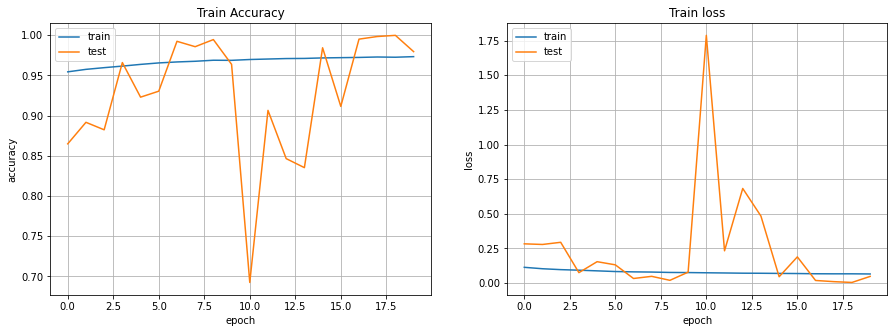

In [ ]:
#summary history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'] ,loc='upper left')
plt.grid()

#summary history for loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'] ,loc='upper left')
plt.grid()
plt.show()

In [ ]:
results = model.evaluate(x_test, y_test, batch_size=128)
print(f"{model.metrics_names} = {results}")

446/446 [==============================] - 1s 3ms/step - loss: 0.0893 - acc: 0.9667
['loss', 'acc'] = [0.0893029198050499, 0.9666619896888733]


In [ ]:
preds_mlp = model.predict(x_test)

In [ ]:
pfm_auc = roc_auc_score(y_test, preds_mlp[:,1])
pfm_f1 = f1_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')
pfm_precision = precision_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')
pfm_recall = recall_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')
print(f"AUC:{pfm_auc}\nF1 Score:{pfm_f1}\nPrecision:{pfm_precision}\nRecall:{pfm_recall}")

AUC:0.9710373360064719
F1 Score:0.9814461515184617
Precision:0.9981237714256764
Recall:0.9666619851831045


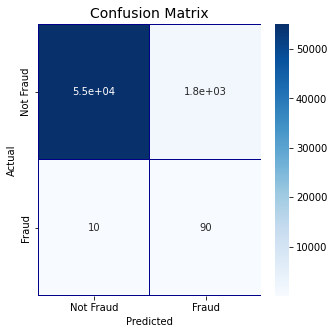

In [ ]:
cm = pd.crosstab(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

# (3 - Run) Loop Training DP-MLP

## Set seed

In [ ]:
import sys
import tensorflow as tf
#seting
np.random.seed(1234)
tf.random.set_seed(5678)
_,input_dim = x_train.shape #the number of features per one input
output_din = len(set(y_train)) #the number of output classes

## Create Function and setting model

In [ ]:
def mlp_training(batchSize ,epochNum ,learnRate ,optzer ,nodes_num=1 ,nodes_act='relu'):
  model = tf.keras.models.Sequential()
  #Input layer
  model.add(tf.keras.Input(shape=(input_dim,)))
  #Hidden -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
  #> 1 layer
  model.add(tf.keras.layers.Dense(nodes_num, activation=nodes_act, name='hidden1')) 
  model.add(tf.keras.layers.BatchNormalization(axis =-1, name='bn1'))
  #> 2 layer
  model.add(tf.keras.layers.Dense(nodes_num, activation=nodes_act, name='hidden2')) 
  model.add(tf.keras.layers.BatchNormalization(axis =-1, name='bn2'))  
  #> 3 layer
  model.add(tf.keras.layers.Dense(nodes_num, activation=nodes_act, name='hidden3')) 
  model.add(tf.keras.layers.BatchNormalization(axis =-1, name='bn3'))  
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  #output layer
  model.add(tf.keras.layers.Dense(2, activation='softmax' , name='output'))

  #Compiling the model
  if optzer.lower() == 'adum':
    opt = tf.keras.optimizers.Adam(learning_rate=learnRate)
  elif optzer.lower() == 'sgd':
    opt = tf.keras.optimizers.SGD(learning_rate=learnRate)
  else :
    print('error optimizers')
  model.compile(optimizer=opt
                      , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
                      , metrics=['acc'])
  #Training
  history = model.fit(x_train, y_train, batch_size=batchSize, epochs=epochNum, verbose=0, validation_split=0.2)
  return model,history

## Loop

In [ ]:
#list of Parameter batchSize ,epochNum ,learnRate ,optzer ,nodes_num=1 ,nodes_act='relu'
lst_batch = [256, 512, 1024]
lst_epoch = [10, 25, 50]
lst_learn = [0.001 ,0.005]
lst_opt = ['adum' ,'sgd']
lst_node = [1,28,56]
lst_activation = ['sigmoid', 'relu']

In [ ]:
#Import last result
#For New Loop
#df_result_MLP = pd.DataFrame()
#Continue from last state
df_result_MLP = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BADS7604_DL/data/mlp_result_l007_c009.csv')
last_step = len(df_result_MLP)
print(f"Last step is : {last_step}")
df_result_MLP.tail(2)

Last step is : 9


,batch_size,epoch,learning_rate,optimizer,num_node,activation,layers,runing_times,auc,f1score,precision,recall,loss,acc
7,256,10,0.001,sgd,1,relu,hidden1|bn1|hidden2|bn2|hidden3|bn3|output,82.772641,0.957397,0.991174,0.998181,0.985359,0.083462,0.985359
8,256,10,0.001,sgd,28,sigmoid,hidden1|bn1|hidden2|bn2|hidden3|bn3|output,82.738010,0.974822,0.992894,0.998264,0.988606,0.067524,0.988606


In [ ]:
count_loop = 0
start_tm = time.time()
for batch_i in lst_batch:
  for epoch_j in lst_epoch:
    for learn_k in lst_learn:
      for opt_l in lst_opt:
        for node_m in lst_node:
          for act_n in lst_activation:
            count_loop =count_loop+1
            if count_loop>last_step:
              inloop_tm = time.time()
              model,_ = mlp_training(batch_i,epoch_j,learn_k,opt_l,node_m,act_n)
              inloop_tm = time.time() - inloop_tm
              preds_mlp = model.predict(x_test)
              results = model.evaluate(x_test, y_test, batch_size=128 , verbose=0)
              #Save Result
              result_dic = {'batch_size':[batch_i]
                              ,'epoch':[epoch_j]
                              ,'learning_rate':[learn_k]
                              ,'optimizer':[opt_l]
                              ,'num_node':[node_m]
                              ,'activation':[act_n]
                              ,'layers':['|'.join([layer.name for layer in model.layers])]
                              ,'runing_times':[inloop_tm]
                              ,'auc':[roc_auc_score(y_test, preds_mlp[:,1])]
                              ,'f1score':[f1_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')]
                              ,'precision':[precision_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')]
                              ,'recall':[recall_score(y_test, np.where(preds_mlp[:,1]>PREDS_RATIO,1,0), average='weighted')]
                              ,'loss':[results[0]]
                              ,'acc':[results[1]]
                              }
              df_result_MLP = df_result_MLP.append(pd.DataFrame(result_dic) ,ignore_index=True)
              print(f"Size of table {df_result_MLP.shape} time: {(time.time() - start_tm)/60:.2f} min")
              #Save Result to google Drive
              df_result_MLP.to_csv(f"/content/drive/MyDrive/Colab Notebooks/BADS7604_DL/data/mlp_result_l{len(model.layers):03d}_c{count_loop:03d}.csv",index=False)
            else :
              print(f"Skip step : {count_loop}")
print(f"Total runing loop : {time.time() - start_tm}")

Skip step : 1
Skip step : 2
Skip step : 3
Skip step : 4
Skip step : 5
Skip step : 6
Skip step : 7
Skip step : 8
Skip step : 9
Size of table (10, 14) time: 0.88 min
Size of table (11, 14) time: 2.33 min
Size of table (12, 14) time: 3.22 min
Size of table (13, 14) time: 4.18 min


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Size of table (14, 14) time: 5.63 min
Size of table (15, 14) time: 6.56 min
Size of table (16, 14) time: 8.00 min
Size of table (17, 14) time: 9.45 min
Size of table (18, 14) time: 10.90 min
Size of table (19, 14) time: 11.78 min


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Size of table (20, 14) time: 13.21 min
Size of table (21, 14) time: 14.09 min
Size of table (22, 14) time: 14.98 min
Size of table (23, 14) time: 16.42 min
Size of table (24, 14) time: 17.87 min
Size of table (25, 14) time: 20.11 min


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Size of table (26, 14) time: 22.55 min
Size of table (27, 14) time: 24.77 min
Size of table (28, 14) time: 27.21 min
Size of table (29, 14) time: 29.42 min
Size of table (30, 14) time: 31.86 min
Size of table (31, 14) time: 34.30 min


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Size of table (32, 14) time: 36.43 min
Size of table (33, 14) time: 38.87 min
Size of table (34, 14) time: 40.98 min
Size of table (35, 14) time: 43.43 min
Size of table (36, 14) time: 45.86 min
Size of table (37, 14) time: 48.30 min


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Size of table (38, 14) time: 50.55 min
Size of table (39, 14) time: 52.78 min
Size of table (40, 14) time: 54.98 min
Size of table (41, 14) time: 57.42 min
Size of table (42, 14) time: 59.86 min
Size of table (43, 14) time: 62.29 min


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Size of table (44, 14) time: 64.39 min
Size of table (45, 14) time: 66.83 min
Size of table (46, 14) time: 69.25 min
Size of table (47, 14) time: 71.68 min
Size of table (48, 14) time: 73.79 min
Size of table (49, 14) time: 78.22 min
Size of table (50, 14) time: 82.62 min
Size of table (51, 14) time: 87.07 min
Size of table (52, 14) time: 91.51 min
Size of table (53, 14) time: 95.94 min
Size of table (54, 14) time: 100.38 min
Size of table (55, 14) time: 104.46 min
Size of table (56, 14) time: 108.91 min
Size of table (57, 14) time: 113.35 min
Size of table (58, 14) time: 117.79 min
Size of table (59, 14) time: 122.22 min
Size of table (60, 14) time: 126.39 min
Size of table (61, 14) time: 130.73 min
Size of table (62, 14) time: 135.17 min
Size of table (63, 14) time: 139.61 min
Size of table (64, 14) time: 144.01 min
Size of table (65, 14) time: 148.31 min
Size of table (66, 14) time: 152.71 min
Size of table (67, 14) time: 156.84 min


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Size of table (68, 14) time: 161.28 min
Size of table (69, 14) time: 165.42 min
Size of table (70, 14) time: 169.54 min
Size of table (71, 14) time: 173.98 min
Size of table (72, 14) time: 178.42 min
Size of table (73, 14) time: 179.20 min


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Size of table (74, 14) time: 179.95 min
Size of table (75, 14) time: 180.47 min
Size of table (76, 14) time: 180.98 min
Size of table (77, 14) time: 181.50 min
Size of table (78, 14) time: 182.02 min
Size of table (79, 14) time: 182.78 min
Size of table (80, 14) time: 183.29 min
Size of table (81, 14) time: 183.79 min
Size of table (82, 14) time: 184.28 min
Size of table (83, 14) time: 185.04 min
Size of table (84, 14) time: 185.55 min
Size of table (85, 14) time: 186.31 min


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Size of table (86, 14) time: 187.06 min
Size of table (87, 14) time: 187.58 min
Size of table (88, 14) time: 188.32 min
Size of table (89, 14) time: 188.82 min
Size of table (90, 14) time: 189.34 min
Size of table (91, 14) time: 190.09 min


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Size of table (92, 14) time: 190.58 min
Size of table (93, 14) time: 191.07 min
Size of table (94, 14) time: 191.84 min
Size of table (95, 14) time: 192.60 min
Size of table (96, 14) time: 193.36 min
Size of table (97, 14) time: 194.55 min
Size of table (98, 14) time: 195.72 min
Size of table (99, 14) time: 196.89 min
Size of table (100, 14) time: 198.34 min
Size of table (101, 14) time: 199.79 min
Size of table (102, 14) time: 200.93 min
Size of table (103, 14) time: 202.03 min
Size of table (104, 14) time: 203.14 min
Size of table (105, 14) time: 204.27 min
Size of table (106, 14) time: 205.70 min
Size of table (107, 14) time: 207.14 min
Size of table (108, 14) time: 208.25 min
Size of table (109, 14) time: 209.45 min


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Size of table (110, 14) time: 210.89 min
Size of table (111, 14) time: 212.34 min
Size of table (112, 14) time: 213.52 min
Size of table (113, 14) time: 214.97 min
Size of table (114, 14) time: 216.43 min
Size of table (115, 14) time: 217.87 min


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Size of table (116, 14) time: 219.32 min
Size of table (117, 14) time: 220.41 min
Size of table (118, 14) time: 221.85 min
Size of table (119, 14) time: 223.29 min
Size of table (120, 14) time: 224.73 min
Size of table (121, 14) time: 227.17 min


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Size of table (122, 14) time: 229.62 min
Size of table (123, 14) time: 232.05 min
Size of table (124, 14) time: 234.49 min
Size of table (125, 14) time: 236.94 min
Size of table (126, 14) time: 239.38 min
Size of table (127, 14) time: 241.82 min
Size of table (128, 14) time: 244.25 min
Size of table (129, 14) time: 246.70 min
Size of table (130, 14) time: 249.14 min
Size of table (131, 14) time: 251.26 min
Size of table (132, 14) time: 253.38 min
Size of table (133, 14) time: 255.82 min


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Size of table (134, 14) time: 258.25 min
Size of table (135, 14) time: 260.69 min
Size of table (136, 14) time: 262.95 min
Size of table (137, 14) time: 265.39 min
Size of table (138, 14) time: 267.59 min
Size of table (139, 14) time: 269.71 min
Size of table (140, 14) time: 271.83 min
Size of table (141, 14) time: 273.93 min
Size of table (142, 14) time: 276.05 min
Size of table (143, 14) time: 278.14 min
Size of table (144, 14) time: 280.58 min
Size of table (145, 14) time: 280.89 min
Size of table (146, 14) time: 281.32 min
Size of table (147, 14) time: 281.73 min
Size of table (148, 14) time: 282.04 min
Size of table (149, 14) time: 282.47 min
Size of table (150, 14) time: 282.90 min
Size of table (151, 14) time: 283.31 min


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Size of table (152, 14) time: 283.60 min
Size of table (153, 14) time: 283.90 min
Size of table (154, 14) time: 284.19 min
Size of table (155, 14) time: 284.50 min
Size of table (156, 14) time: 284.92 min
Size of table (157, 14) time: 285.23 min


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Size of table (158, 14) time: 285.55 min
Size of table (159, 14) time: 285.88 min
Size of table (160, 14) time: 286.18 min
Size of table (161, 14) time: 286.50 min
Size of table (162, 14) time: 286.92 min
Size of table (163, 14) time: 287.23 min


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Size of table (164, 14) time: 287.64 min
Size of table (165, 14) time: 287.94 min
Size of table (166, 14) time: 288.25 min
Size of table (167, 14) time: 288.53 min
Size of table (168, 14) time: 288.93 min
Size of table (169, 14) time: 289.59 min
Size of table (170, 14) time: 290.23 min
Size of table (171, 14) time: 290.87 min
Size of table (172, 14) time: 291.63 min
Size of table (173, 14) time: 292.27 min
Size of table (174, 14) time: 292.90 min
Size of table (175, 14) time: 293.64 min
Size of table (176, 14) time: 294.28 min
Size of table (177, 14) time: 295.03 min
Size of table (178, 14) time: 295.79 min
Size of table (179, 14) time: 296.41 min
Size of table (180, 14) time: 297.15 min
Size of table (181, 14) time: 297.79 min
Size of table (182, 14) time: 298.44 min
Size of table (183, 14) time: 299.19 min
Size of table (184, 14) time: 299.95 min
Size of table (185, 14) time: 300.58 min
Size of table (186, 14) time: 301.34 min
Size of table (187, 14) time: 301.96 min


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Size of table (188, 14) time: 302.57 min
Size of table (189, 14) time: 303.19 min
Size of table (190, 14) time: 303.95 min
Size of table (191, 14) time: 304.57 min
Size of table (192, 14) time: 305.17 min
Size of table (193, 14) time: 306.61 min
Size of table (194, 14) time: 308.06 min
Size of table (195, 14) time: 309.50 min
Size of table (196, 14) time: 310.70 min
Size of table (197, 14) time: 312.14 min
Size of table (198, 14) time: 313.36 min
Size of table (199, 14) time: 314.80 min
Size of table (200, 14) time: 315.95 min
Size of table (201, 14) time: 317.11 min
Size of table (202, 14) time: 318.54 min
Size of table (203, 14) time: 319.99 min
Size of table (204, 14) time: 321.12 min
Size of table (205, 14) time: 322.34 min
Size of table (206, 14) time: 323.77 min
Size of table (207, 14) time: 325.21 min
Size of table (208, 14) time: 326.43 min
Size of table (209, 14) time: 327.88 min
Size of table (210, 14) time: 329.08 min
Size of table (211, 14) time: 330.25 min


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Size of table (212, 14) time: 331.38 min
Size of table (213, 14) time: 332.82 min
Size of table (214, 14) time: 333.98 min
Size of table (215, 14) time: 335.41 min
Size of table (216, 14) time: 336.55 min
Total runing loop : 20192.990369796753


In [ ]:
Save result : https://docs.google.com/spreadsheets/d/1CtRk7Nco5w2Nefw355E39Xh0Xkl71nQDtBV6u_2n-5U/edit#gid=1840033743